# Carregue as bibliotecas necessárias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import json
import matplotlib.pyplot as plt
import numpy as np

## Carregue o conjunto de dados

In [2]:
# Carregue o conjunto de dados gerado a partir do script dataset_generator.py e os separe em data e target
dados = {}
with open('./dataset.json', 'r') as arquivo:
    dados = json.load(arquivo)

data = [(d['coords']) for d in dados['dados']]
target = [d['params'] for d in dados['dados']]

## Normalize os dados

In [3]:
# Converta 'data' para um array bidimensional
data_flattened = [sample for series in data for sample in series]

# Crie uma instância do MinMaxScaler e ajuste aos dados
scaler = MinMaxScaler()
scaler.fit(data_flattened)

# Normalize os dados
data_normalized = [scaler.transform(series) for series in data]

scaler.fit(target)

# Normalize os rótulos
target_normalized = scaler.transform(target)


## Separe os dados em treino e teste

In [4]:
test_size = 0.2   # 20% dos dados para teste
train_data, test_data, train_target, test_target = train_test_split(
    data_normalized, target_normalized, test_size=test_size, random_state=42)

## Defina a arquitetura da rede neural

In [5]:
# Formato dos dados
num_coords = 128
coord_dim = 2
num_params = 4
occult_layer = 64

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_coords * coord_dim, num_coords)
        self.fc2 = nn.Linear(num_coords, occult_layer)
        self.fcn = nn.Linear(occult_layer, num_params)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fcn(x)
        return x

## Defina parâmetros para o treinamento do modelo

In [6]:
# Defina função de perda e o otimizador
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Ajuste o learning rate conforme necessário

# Defina parâmetros para o treinamento
num_epochs = 100
batch_size = 12
train_losses = []
val_losses = []

# Treine o modelo com a técnica K-Fold Cross Validation

In [7]:
train_dataset_size = len(train_data)
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(k_fold.split(range(train_dataset_size))):
    # Configure os conjuntos de dados e rótulos
    x_train_set = np.array(torch.utils.data.Subset(train_data, train_indices))
    y_train_set = np.array(torch.utils.data.Subset(train_target, train_indices))
    x_val_set = np.array(torch.utils.data.Subset(train_data, val_indices))
    y_val_set = np.array(torch.utils.data.Subset(train_target, val_indices))

    x_train_tensor = torch.Tensor(x_train_set)
    y_train_tensor = torch.Tensor(y_train_set)
    x_val_tensor = torch.Tensor(x_val_set)
    y_val_tensor = torch.Tensor(y_val_set)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    running_loss = 0.0
    running_val_loss = 0.0

    # Treine e valide o modelo
    for epoch in range(num_epochs):
        model.train()

        # Loop de treinamento
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        train_losses.append(loss.item())

        # Loop de validação
        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                running_val_loss += val_loss.item()    
            val_losses.append(val_loss.item())
    
    average_train_loss = running_loss / len(train_loader)
    average_val_loss = running_val_loss / len(val_loader)
    print(f'Fold: {fold+1}, average_train_loss: {average_train_loss}, average_val_loss: {average_val_loss}')
    
        

Fold: 1, average_train_loss: 0.8932142325362226, average_val_loss: 1.933051852675687
Fold: 2, average_train_loss: 0.217213983866343, average_val_loss: 0.769373657531105
Fold: 3, average_train_loss: 0.09250577129784722, average_val_loss: 0.25460099994337987
Fold: 4, average_train_loss: 0.05114822006719435, average_val_loss: 0.1203255915232668
Fold: 5, average_train_loss: 0.041490095315667636, average_val_loss: 0.09647809417635601


In [145]:
# Salve o modelo
path = 'modelo1.pth'
torch.save(model.state_dict(), path)

# Curvas de aprendizado para treino e validação

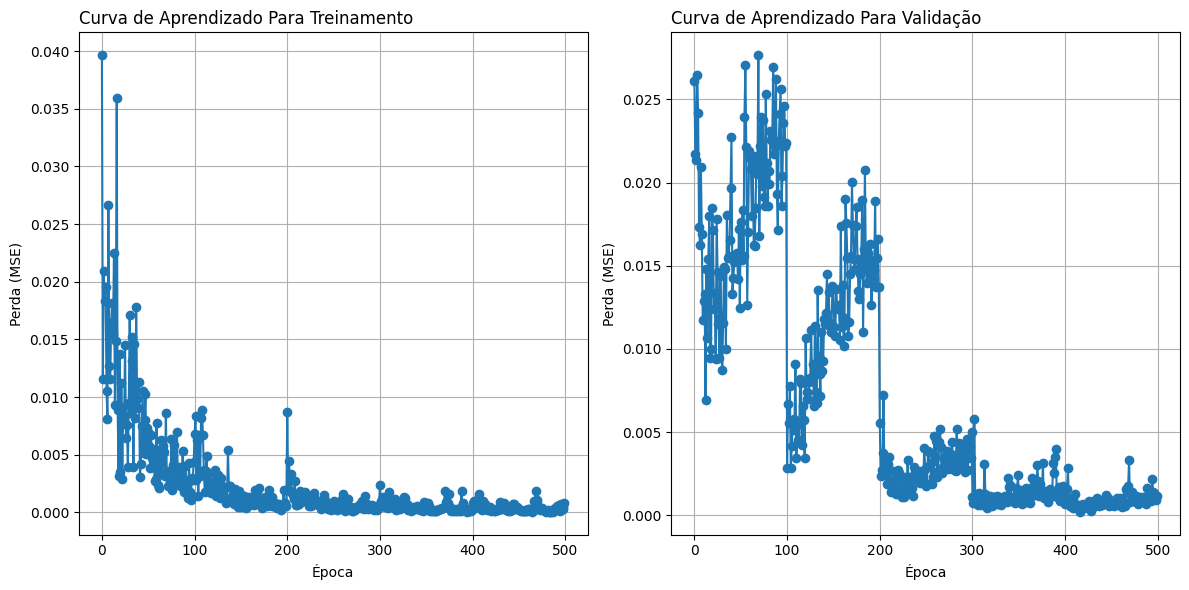

In [8]:
plt.figure(figsize=(12, 6))

# Primeiro gráfico (train_losses)
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, marker='o', linestyle='-')
plt.xlabel('Época')
plt.ylabel('Perda (MSE)')
plt.title('Curva de Aprendizado Para Treinamento', loc='left')
plt.grid(True)

# Segundo gráfico (val_losses)
plt.subplot(1, 2, 2)
plt.plot(range(len(val_losses)), val_losses, marker='o', linestyle='-')
plt.xlabel('Época')
plt.ylabel('Perda (MSE)')
plt.title('Curva de Aprendizado Para Validação', loc='left')
plt.grid(True)


plt.tight_layout()
plt.savefig('comparação_mse_treino_val.png')
plt.show()

# Distribuição dos pesos

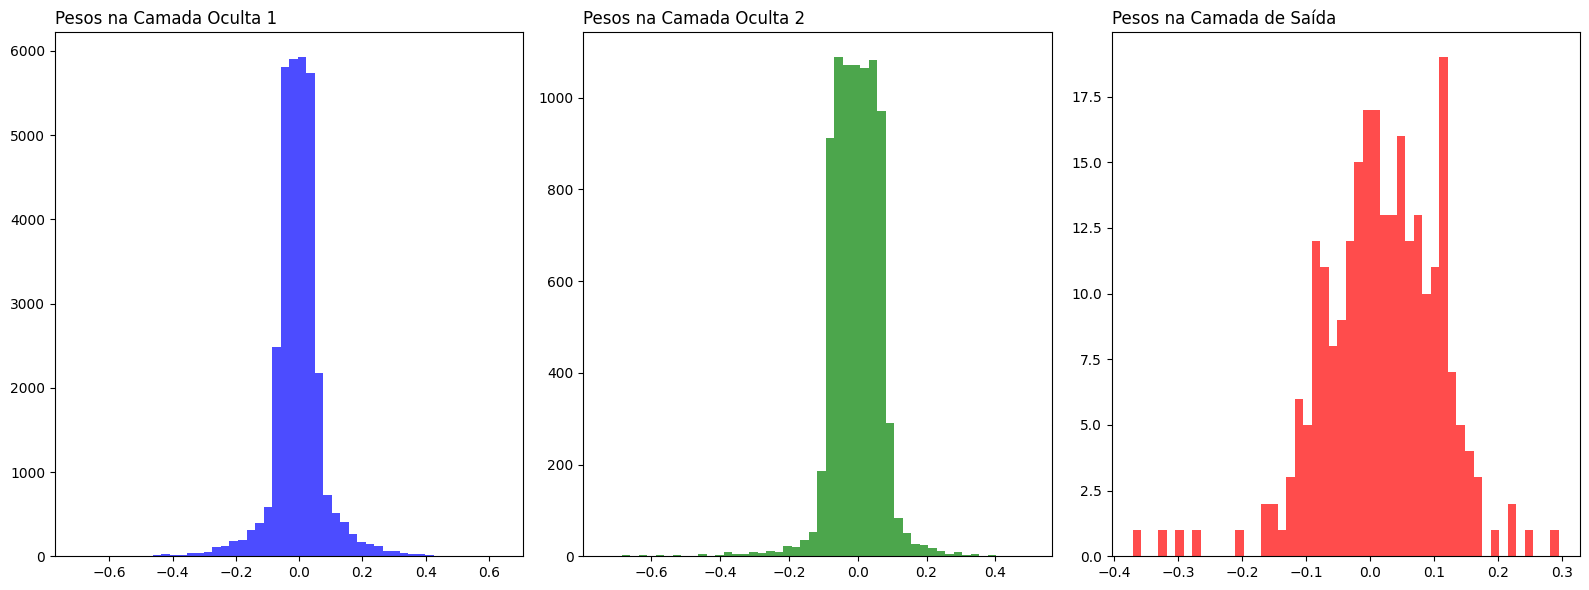

In [9]:
pesos_fc1 = model.fc1.weight.data.numpy().flatten()
pesos_fc2 = model.fc2.weight.data.numpy().flatten()
pesos_fcn = model.fcn.weight.data.numpy().flatten()

plt.figure(figsize=(16, 6))

# Gráfico 1
plt.subplot(1, 3, 1)
plt.hist(pesos_fc1, bins=50, color='blue', alpha=0.7)
plt.title('Pesos na Camada Oculta 1', loc='left')

# Gráfico 2
plt.subplot(1, 3, 2)
plt.hist(pesos_fc2, bins=50, color='green', alpha=0.7)
plt.title('Pesos na Camada Oculta 2', loc='left')

# Gráfico 3
plt.subplot(1, 3, 3)
plt.hist(pesos_fcn, bins=50, color='red', alpha=0.7)
plt.title('Pesos na Camada de Saída', loc='left')

plt.tight_layout()
plt.savefig('pesos.png')
plt.show()


## Avalie o modelo com os dados de teste

In [10]:
x_test_tensor = torch.Tensor(test_data)
y_test_tensor = torch.Tensor(test_target)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.eval()
test_loss = 0.0
test_losses = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        test_loss += criterion(outputs, batch_y).item()
        test_losses.append(criterion(outputs, batch_y).item())

average_test_loss = test_loss / len(test_loader)
average_test_loss

C:\Users\henri\AppData\Local\Temp\ipykernel_12548\2258136281.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  x_test_tensor = torch.Tensor(test_data)


0.02108623257235569

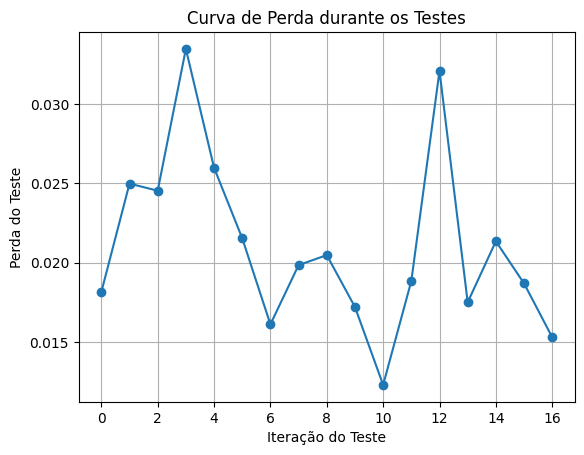

In [11]:
# Plote a curva de perda durante os testes
plt.plot(test_losses, marker='o', linestyle='-')
plt.xlabel('Iteração do Teste')
plt.ylabel('Perda do Teste')
plt.title('Curva de Perda durante os Testes')
plt.grid(True)
plt.show()

# Teste novos dados

In [12]:
with open('./new_data.json', 'r') as arquivo:
    dados = json.load(arquivo)

pontos = [(d['coords']) for d in dados['dados']][0]
params = [d['params'] for d in dados['dados']]

scaler.fit(pontos)

pontos_n = scaler.transform(pontos)


pontos_tensor = torch.Tensor(pontos_n)

previsao = model(pontos_tensor.unsqueeze(0))

def calcula_mse(predictions, labels):
    mse = ((predictions - labels) ** 2).mean()
    return mse.item(), torch.sqrt(mse)

mse, rmse = calcula_mse(previsao, y_test_tensor)
print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}')


MSE: 0.1535, RMSE: 0.3918


# Compare visualmente a previsão com o dado orignal

In [13]:
# Função para gerar o gráfico
def plot_grafico(linhas, new_data, ax, titulo):
    # Defina o tamanho do gráfico
    x_min, x_max = 0, 6000
    y_min, y_max = 0, 8
    dmin, dmax = linhas[2], linhas[3]
    tl, th = linhas[0], linhas[1]

    x_line = [
        [x_min, 
        dmin, dmin,
        dmax, dmax,
        x_max]
    ]

    y_line = [
        [tl, tl,
        th, th,
        tl, tl]
    ]

    ax.plot(x_line[0], y_line[0], color='red')

    ax.scatter([x[0] for x in new_data], [y[1] for y in new_data], c='blue')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(titulo, loc='left')

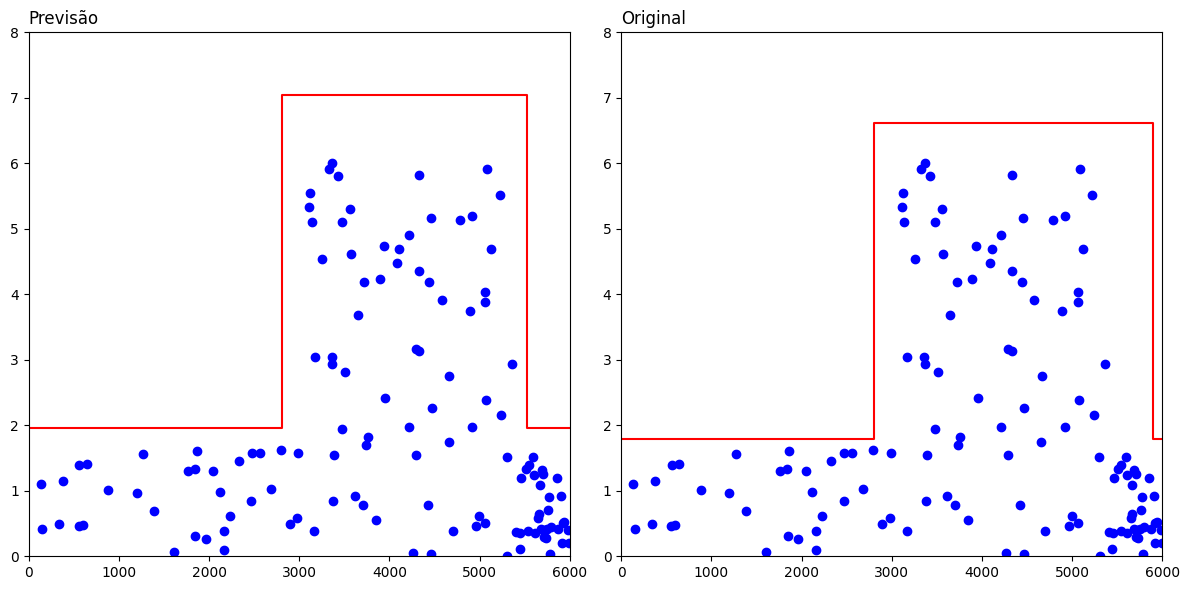

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Converta a previsão para coordenadas no gráfico
scaler.fit(target)
previsao_c = scaler.inverse_transform(previsao.detach().numpy())
linhas = previsao_c.tolist()[0]

plot_grafico(linhas, pontos, axs[0], "Previsão")
plot_grafico(params[0], pontos, axs[1], "Original")
plt.savefig('comparação_previsao_original.png')
plt.tight_layout()
plt.show()